# Mod4 Project

## Import Libraries

In [1]:
from math import log
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from collections import defaultdict
import sklearn
import sklearn.metrics



# pd.set_option("display.max_rows", None, "display.max_columns", None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import data files
movies_df = pd.read_csv('movies.csv',index_col=False)
ratings_df = pd.read_csv('ratings.csv',index_col=False)
tags_df = pd.read_csv('tags.csv',index_col=False)

First thing is to look at each file to get an idea of what is contained. Then we will merge any relavent data sets and perform some EDA

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


We're going to drop the timestamp column as it is not useful for our model

In [5]:
ratings_df.drop(columns='timestamp',inplace=True)

In [6]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:

movies_df.set_index('movieId')

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


In [8]:
df = pd.merge(movies_df,tags_df, on='movieId', how='left')

In [9]:
tags_df.shape

(3683, 4)

In [10]:
ratings_df.shape

(100836, 3)

In [11]:
df.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,1.525286e+09
3,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,1.528844e+09
4,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,magic board game,1.528844e+09


In [12]:
df.shape

(11853, 6)

## EDA

The first data we'll look at is for the collaborative model will just be using the ratings dataframe

In [13]:
#Look at column types
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
userId     100836 non-null int64
movieId    100836 non-null int64
rating     100836 non-null float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [14]:
#Check for null values
ratings_df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [15]:
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

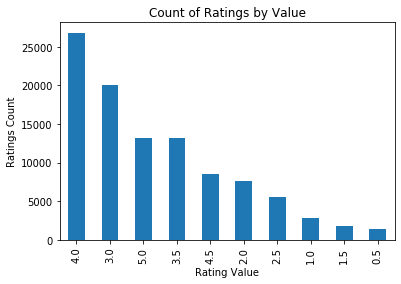

In [16]:

fig, ax = plt.subplots()
ax = ratings_df['rating'].value_counts().plot(kind='bar')
ax.set_xlabel('Rating Value')  # Add an x-label to the axes.
ax.set_ylabel('Ratings Count')  # Add a y-label to the axes.
ax.set_title("Count of Ratings by Value")  # Add a title to the axes.
plt.show()

## Collaborative Model

The first thing we are going to do is build some baseline Collaborative Recommendation models. We will begin with Surprise and loading in our data. We'll first look at RMSE for evaluation but then expand to other metrics.

In [17]:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)

Let's look at how many users and items we have in our dataset. If using neighborhood-based methods, this will help us determine whether or not we should perform user-user or item-item similarity

In [18]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [19]:
#Creating SVD Model and showing RMSE
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8694818921687506, 'mae': 0.6683445129127895}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 100, 'reg_all': 0.05}}


In [20]:
sim_metrics = ['pearson','MSD','cosine','pearson_baseline']
#Creating Basic KNN Model and showing RMSE, checking all distance metrics
for metric in sim_metrics:
    knn_basic = KNNBasic(sim_options={'name': metric, 'user_based':True})
    cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
    print('Similarity Metric = ', metric,'---', 'test_rmse = ', np.mean(cv_knn_basic['test_rmse']),'\n')
    
    

Similarity Metric =  pearson --- test_rmse =  0.9731327088934169 

Similarity Metric =  MSD --- test_rmse =  0.9477889432315022 

Similarity Metric =  cosine --- test_rmse =  0.9711473637678887 

Similarity Metric =  pearson_baseline --- test_rmse =  0.9717477677389436 



In [21]:
# cross validating with KNNBaseline
for metric in sim_metrics:
    knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
    cv_knn_baseline = cross_validate(knn_baseline,data)
    print('Similarity Metric = ', metric,'---', 'test_rmse = ', np.mean(cv_knn_baseline['test_rmse']),'\n')

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Similarity Metric =  pearson --- test_rmse =  0.8771035453844339 

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matri

### Trying hit rate as an evaluation

In [22]:
trainSet, testSet = train_test_split(data, test_size=.25, random_state=0)

In [23]:
#Get top 10 predictions for ratings above 4
def GetTopN(predictions, n=10, minimumRating=4.0):
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN
    
LOOCV = LeaveOneOut(n_splits=1, random_state=1)



In [69]:
#Get top predictions 
#When I use n=10 for knn it gets 0 hits, expanding to 50 it got a positive non-zero amount
#so I am confident it is working just doing a worse job likely due to sparseness. I expanded
#both to 50 for now
svd_model= SVD(n_factors=50,reg_all=0.05)
KNN_model= KNNBaseline(sim_options={'name':'pearson', 'user_based':True})

for trainSet, testSet in LOOCV.split(data):
    # Train model without left-out ratings
    svd_model.fit(trainSet)
    leftOutPredictionsSVD = svd_model.test(testSet)
    bigTestSet = trainSet.build_anti_testset()
    allPredictionsSVD = svd_model.test(bigTestSet)
    
    KNN_model.fit(trainSet)
    leftOutPredictionsKNN = KNN_model.test(testSet)
    bigTestSet = trainSet.build_anti_testset()
    allPredictionsKNN = KNN_model.test(bigTestSet)
   
  
    # Compute top 50 recs for each user
    topNPredictedSVD = GetTopN(allPredictionsSVD, n=50)
    topNPredictedKNN = GetTopN(allPredictionsKNN, n=50)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [25]:
def HitRate(topNPredicted, leftOutPredictions):
    hits = 0
    total = 0

 # For each left-out rating
    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutMovieID = leftOut[1]
        # Is it in the predicted top 50 for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == int(movieID)):
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1

    # Compute overall precision
    return hits/total


In [26]:
print("\nHit Rate SVD: ", HitRate(topNPredictedSVD, leftOutPredictionsSVD))
print("\nHit Rate KNN: ", HitRate(topNPredictedKNN, leftOutPredictionsKNN))


Hit Rate SVD:  0.07868852459016394

Hit Rate KNN:  0.003278688524590164


In [27]:
def RatingHitRate(topNPredicted, leftOutPredictions):
    hits = defaultdict(float)
    total = defaultdict(float)
    # For each left-out rating
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Is it in the predicted top N for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == movieID):
                hit = True
                break
        if (hit) :
            hits[actualRating] += 1
        total[actualRating] += 1

    # Compute overall precision
    for rating in sorted(hits.keys()):
        print(rating, hits[rating] / total[rating])

In [28]:
print("Hit Rate by Rating value SVD: ")
RatingHitRate(topNPredictedSVD, leftOutPredictionsSVD)

Hit Rate by Rating value SVD: 
2.5 0.06666666666666667
3.0 0.02608695652173913
3.5 0.041666666666666664
4.0 0.07222222222222222
4.5 0.22641509433962265
5.0 0.13821138211382114


In [29]:
print("Hit Rate by Rating value KNN: ")
RatingHitRate(topNPredictedKNN, leftOutPredictionsKNN)

Hit Rate by Rating value KNN: 
4.0 0.005555555555555556
5.0 0.008130081300813009


In [30]:
def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=0):
    hits = 0
    total = 0
    # For each left-out rating
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Only look at ability to recommend things the users actually liked...
        if (actualRating >= ratingCutoff):
            # Is it in the predicted top 10 for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == movieID):
                    hit = True
                    break
            if (hit) :
                hits += 1
            total += 1

        # Compute overall precision
    return hits/total

In [31]:
print("Cumulative Hit Rate SVD (rating >= 4): ", CumulativeHitRate(topNPredictedSVD, leftOutPredictionsSVD, 4.0))
print("Cumulative Hit Rate KNN(rating >= 4): ", CumulativeHitRate(topNPredictedKNN, leftOutPredictionsKNN, 4.0))



Cumulative Hit Rate SVD (rating >= 4):  0.11797752808988764


In [33]:
def AverageReciprocalHitRank(topNPredicted, leftOutPredictions):
    summation = 0
    total = 0
        # For each left-out rating
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Is it in the predicted top N for this user?
        hitRank = 0
        rank = 0
        for movieID, predictedRating in topNPredicted[int(userID)]:
            rank = rank + 1
            if (int(leftOutMovieID) == movieID):
                hitRank = rank
                break
        if (hitRank > 0) :
                summation += 1.0 / hitRank

        total += 1

    return summation / total

In [75]:
print("Average Reciprocal Hit Rank SVD: ", AverageReciprocalHitRank(topNPredictedSVD, leftOutPredictionsKNN))
print("Average Reciprocal Hit Rank KNN: ", AverageReciprocalHitRank(topNPredictedKNN, leftOutPredictionsKNN))


Average Reciprocal Hit Rank SVD:  0.009512677876033595
Average Reciprocal Hit Rank KNN:  0.00017041000647558026


In [118]:
def dcg(scores):
    assert scores
    return scores[0] sum(sc / log(ind, 2) for sc, ind in zip(scores[1:], range(2, len(scores)+1)))

def ndcg(predicted_scores, user_scores):
    assert len(predicted_scores) == len(user_scores)
    idcg = dcg(sorted(user_scores, reverse=True))
    return (dcg(predicted_scores) / idcg) if idcg > 0.0 else 0.0

In [119]:
testRatings = []
for row in testSet:
    testRatings.append(row[2])
predRatingsSVD = []
for row in leftOutPredictionsSVD:
    predRatingsSVD.append(row[3])
predRatingsKNN = []
for row in leftOutPredictionsKNN:
    predRatingsKNN.append(row[3])

In [120]:
print('NDCG Value SVD:', ndcg(predRatingsSVD,testRatings))
print('NDCG Value KNN:', ndcg(predRatingsKNN,testRatings))

NDCG Value SVD: 0.9472480195254469
NDCG Value KNN: 0.9537237238490631


In [121]:
dcg(testRatings)

300.99982660453685

In [99]:
diff = []
for i in range(0,len(predRatingsSVD)):
    diff.append(abs(predRatingsSVD[i]-predRatingsKNN[i]))
np.mean(diff)

0.1896877077900542

[0.1750840525795887,
 0.054513872131246366,
 0.05523239410818448,
 0.18518193709513397,
 0.14178900732309074,
 0.494313320740134,
 0.17733126527442789,
 0.27502958883405393,
 0.30398183568290627,
 0.2195241915276842,
 0.1351000940908218,
 0.23759918554220327,
 0.07076526611147305,
 0.018085376885584648,
 0.42936393915255744,
 0.3158420018973418,
 0.23442010344313458,
 0.0391962126807468,
 0.5639167087775165,
 0.09022595247899323,
 0.6166016455770063,
 0.34285925893864855,
 0.016831154907491985,
 0.10412557427198799,
 0.09223496484715454,
 0.22863963817730726,
 0.6265471396568745,
 0.1812823450883574,
 0.3181739298296602,
 0.547024238632388,
 0.09029607584550581,
 0.05613440396230018,
 0.11457739406142498,
 0.059809562411602624,
 0.19072273300487108,
 0.14311860673162569,
 0.31939295654886424,
 0.018974475637761667,
 0.10271734995515303,
 0.12690501553451483,
 0.22961732149179115,
 0.22067556272884836,
 0.11531022161466842,
 0.5734666142640585,
 0.052752363276708625,
 0.1920253708225017

Its pretty clear that the SVD model is outperforming the KNN model here. It was slightly better using RMSE and is significantly better using a hit rate method.

## Make recommendations

In [ ]:
def movie_rec(movie_df,n_ratings=4, genre=None,n_recs=5):
    '''This function takes in the movies dataframe, number of new ratings, genre choice, and
    number of recommendations requested and returns that many reccomendations'''
    userID = 1000
    rating_list = []
    while n_ratings > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            n_ratings -= 1
    ratings_df2 = ratings_df.append(rating_list,ignore_index=True)
    new_data = Dataset.load_from_df(ratings_df2,reader)
    svd_model= SVD(n_factors=50,reg_all=0.05)
    svd_model.fit(new_data.build_full_trainset())
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
    list_of_movies = []
    for m_id in ratings_df2['movieId'].unique():
        list_of_movies.append( (m_id,svd_model.predict(1000,m_id)[3]))
    
# order the predictions from highest to lowest rated
    ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
    for idx, rec in enumerate(ranked_movies):
            title = movies_df.loc[movies_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n_recs-= 1
            if n_recs == 0:
                break

In [ ]:
n_ratings=4
n_recs=10

In [ ]:
movie_rec(movies_df, n_ratings,'Comedy',n_recs)